<a href="https://colab.research.google.com/github/shelleyg-bit/canada-land-cover-classifier/blob/main/rasterio_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# rtree and pygeos are required for geopandas.overlay
!pip install rasterio geopandas rtree pygeos

     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 1.0 MB 45.2 MB/s 
     |████████████████████████████████| 1.0 MB 38.7 MB/s 
     |████████████████████████████████| 2.1 MB 38.0 MB/s 
     |████████████████████████████████| 16.7 MB 43.5 MB/s 
     |████████████████████████████████| 6.3 MB 49.1 MB/s 


In [3]:
!git clone https://github.com/simonkassel/python-satellite-imagery-workshop.git

Cloning into 'python-satellite-imagery-workshop'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 79 (delta 5), reused 11 (delta 2), pack-reused 58
Unpacking objects: 100% (79/79), done.


## Why Rasterio and Not GDAL?
- rasterio is python API for GDAL's C++ backend
- it manages many of gotchas around GDAL python bindings
https://rasterio.readthedocs.io/en/latest/intro.html
https://gdal.org/api/python.html

## Basics

In [4]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint


/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [5]:
import os
project_dir = 'python-satellite-imagery-workshop'

In [6]:
!head -n 50 python-satellite-imagery-workshop/buildings.geojson

{
    "type": "FeatureCollection",
    "crs": {
        "type": "name",
        "properties": {
            "name": "urn:ogc:def:crs:EPSG::32636"
        }
    },
    "features": [
        {
            "type": "Feature",
            "properties": {
                "condition": "good",
                "material": "cement_block"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            459626.5961106891,
                            28121.568562214343
                        ],
                        [
                            459626.8635116092,
                            28133.594468839576
                        ],
                        [
                            459635.69885682187,
                            28134.35689317324
                        ],
                        [
                            459635.2088325734,
                         

Vector Data = Points, Lines and Polygons
online tool geojson.io -> allows to make a polygon


In [7]:
buildings = gpd.read_file(f'{project_dir}/buildings.geojson')
buildings.head()

condition      material                                           geometry
0      good  cement_block  POLYGON ((459626.596 28121.569, 459626.864 281...
1      good      concrete  POLYGON ((459416.838 28816.900, 459436.701 288...
2      good  cement_block  POLYGON ((459415.913 28385.227, 459426.062 283...
3      good  cement_block  POLYGON ((459402.927 28369.620, 459400.112 283...
4      good  cement_block  POLYGON ((459410.038 28399.796, 459413.944 283...

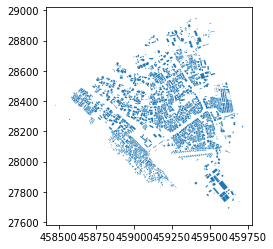

In [8]:
buildings.plot()

In [9]:
b1 = buildings['geometry'].loc[1]

In [10]:
b1.centroid.xy # centroid of building 

(array('d', [459431.05230464344]), array('d', [28805.71192215209]))

In [11]:
b1.area

664.0568703581537

 ### CRS 
 Choose a coordinate system which makes sense for your area of study and which minimizes the error the most for your application
 https://epsg.io/32636

In [12]:
buildings.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Raster Data

### stored in tif file because Metadata is built into file
- you will loose the metadata after conversion into png

In [13]:
!gdalinfo python-satellite-imagery-workshop/img.tif

Driver: GTiff/GeoTIFF
Files: python-satellite-imagery-workshop/img.tif
Size is 6000, 6000
Coordinate System is:
PROJCS["WGS 84 / UTM zone 36N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",33],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32636"]]
Origin = (459286.620712036266923,28083.912440528732986)
Pixel Size = (0.035334835417146,-0.035334911276513)
Metadata:
  A

### Note - Missing Data
Alpha Band refers to missing data (TODO: Read more)

In [14]:
with rasterio.open(f'{project_dir}/img.tif', 'r') as src:
    img = src.read() # 2D array of RGB values, one element in array = one pixel
img

array([[[ 93,  97, 101, ..., 140, 139, 143],
        [100,  95,  91, ..., 163, 162, 166],
        [ 97,  87,  85, ..., 164, 165, 169],
        ...,
        [107, 104, 102, ..., 191, 182, 179],
        [109, 104, 101, ..., 148, 181, 164],
        [ 96,  93,  94, ...,  83, 125, 138]],

       [[ 97,  96,  95, ..., 124, 122, 125],
        [103,  96,  90, ..., 146, 146, 151],
        [ 98,  90,  88, ..., 147, 150, 156],
        ...,
        [122, 119, 117, ..., 180, 173, 173],
        [124, 119, 116, ..., 135, 170, 155],
        [111, 108, 109, ...,  62, 105, 118]],

       [[ 61,  62,  62, ...,  98,  96,  98],
        [ 66,  60,  57, ..., 121, 121, 125],
        [ 61,  54,  54, ..., 124, 126, 131],
        ...,
        [ 57,  54,  52, ..., 164, 167, 161],
        [ 59,  54,  51, ..., 113, 157, 140],
        [ 46,  43,  44, ...,  37,  86,  99]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ..

In [15]:
img.shape # (bands, pixel_h, pixel_w)

(4, 6000, 6000)

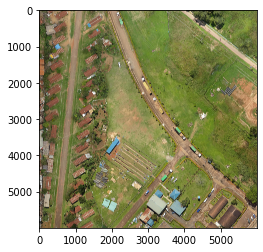

In [16]:
plt.imshow(img.T)

## Windowed reading

In [17]:
with rasterio.open(f'{project_dir}/img.tif') as src:
    width = src.width
    height = src.height
    p = src.profile.copy()

In [18]:
p

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6000, 'height': 6000, 'count': 4, 'crs': CRS.from_epsg(32636), 'transform': Affine(0.03533483541714589, 0.0, 459286.62071203627,
       0.0, -0.035334911276512705, 28083.912440528733), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'jpeg', 'interleave': 'pixel'}

#### Extract 1000x1000 center square from image

In [19]:
aoi_h = 1000
aoi_w = aoi_h
row_start = height/2 - (aoi_h/2)
col_start = width/2 - (aoi_w/2)

In [20]:
print(row_start, col_start)

2500.0 2500.0


In [21]:
pprint(p['transform'])

Affine(0.03533483541714589, 0.0, 459286.62071203627,
       0.0, -0.035334911276512705, 28083.912440528733)


In [22]:
from rasterio.features import Window
from rasterio.windows import bounds
win = Window(col_off=col_start, row_off=row_start, width=1000, height=1000)

In [23]:
# Create transform for the window
x = rasterio.open(f'{project_dir}/img.tif').window_transform(win)
x

Affine(0.03533483541714589, 0.0, 459374.95780057914,
       0.0, -0.035334911276512705, 27995.575162337453)

In [24]:
2500*0.03533483541714589 + 459286.62071203627
28083.912440528733 - 2500*0.03533483541714589

27995.57535198587

In [25]:
with rasterio.open(f'{project_dir}/img.tif') as src:
    f = src.read(window=win) # reads the center portion of the image
    # copy relevant metadata from source image
    p = src.profile.copy()
    p['width'] = win.width 
    p['height'] = win.height
    p['transform'] = src.window_transform(win)


In [26]:
f.shape

(4, 1000, 1000)

In [27]:
with rasterio.open('sample.tif', 'w', **p) as dst:
    dst.write(f)

In [28]:
with rasterio.open(f'sample.tif', 'r') as src:
    img = src.read() # 2D array of RGB values, one element in array = one pixel
img.T.shape # transposes array shape

(1000, 1000, 4)

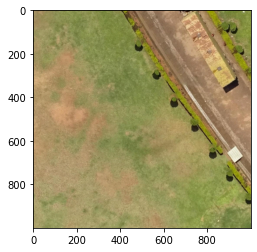

In [29]:
plt.imshow(img.T)

# Processing Data for ML

In [30]:
buildings

condition      material  \
0         good  cement_block   
1         good      concrete   
2         good  cement_block   
3         good  cement_block   
4         good  cement_block   
...        ...           ...   
3924      poor         brick   
3925      poor    metal;wood   
3926   average         brick   
3927      poor         brick   
3928      poor         brick   

                                               geometry  
0     POLYGON ((459626.596 28121.569, 459626.864 281...  
1     POLYGON ((459416.838 28816.900, 459436.701 288...  
2     POLYGON ((459415.913 28385.227, 459426.062 283...  
3     POLYGON ((459402.927 28369.620, 459400.112 283...  
4     POLYGON ((459410.038 28399.796, 459413.944 283...  
...                                                 ...  
3924  POLYGON ((459145.088 27926.680, 459146.067 279...  
3925  POLYGON ((459021.426 27916.217, 459024.475 279...  
3926  POLYGON ((459066.106 28001.690, 459067.697 280...  
3927  POLYGON ((459019.915 27994.109, 459021.740 279...  
3928  POLYGON ((458959.125 28021.434, 458961.741 280...  

[3929 rows x 3 columns]

In [31]:
buildings.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Clip buildings dataset to img dataset

In [32]:
with rasterio.open(f'{project_dir}/img.tif') as src:
    bounds = src.bounds
    img_crs=src.crs

In [33]:
img_crs

CRS.from_epsg(32636)

In [34]:
bounds
l,b,r,t = bounds

In [51]:
bounds

BoundingBox(left=459286.62071203627, bottom=27871.902972869655, right=459498.6297245391, top=28083.912440528733)

In [35]:
from shapely.geometry import Polygon


In [36]:
img_bbox = Polygon([(l, b), (l, t), (r, t), (r, b)])

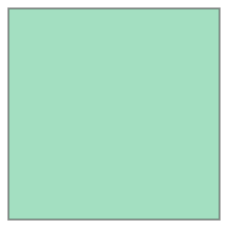

In [37]:
img_bbox

In [38]:
#TODO Plot bounding box on the image

In [39]:
bbox_gdf = gpd.GeoDataFrame({'geometry': [img_bbox]}, crs=img_crs) # Force the geometry into gdf so its easy to concat with buildings

In [40]:
bbox_gdf

geometry
0  POLYGON ((459286.621 27871.903, 459286.621 280...

In [41]:
buildings.to_file('buildings.shp')

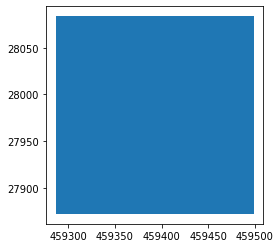

In [42]:
bbox_gdf.plot()

In [43]:
bldgs = gpd.overlay(buildings, bbox_gdf, how='intersection') # finds the intersection of buildings and bbox

In [44]:
bldgs

condition                     material  \
0       good     cement_block;metal;brick   
1       good     cement_block;metal;brick   
2       good               concrete;metal   
3       good  concrete;cement_block;stone   
4    average                        brick   
..       ...                          ...   
81   average                        brick   
82   average                 cement_block   
83   average                        brick   
84   average                        brick   
85   average                        brick   

                                             geometry  
0   POLYGON ((459484.914 27919.343, 459489.543 279...  
1   POLYGON ((459492.714 27909.925, 459498.630 279...  
2   POLYGON ((459491.891 27915.739, 459498.630 279...  
3   POLYGON ((459487.408 27967.070, 459477.270 279...  
4   POLYGON ((459389.164 28042.224, 459381.697 280...  
..                                                ...  
81  POLYGON ((459456.921 28081.903, 459460.504 280...  
82  POLYGON ((459449.009 28082.158, 459444.314 280...  
83  POLYGON ((459438.549 28082.678, 459438.850 280...  
84  POLYGON ((459437.570 28083.617, 459436.213 280...  
85  POLYGON ((459433.509 28081.163, 459430.259 280...  

[86 rows x 3 columns]

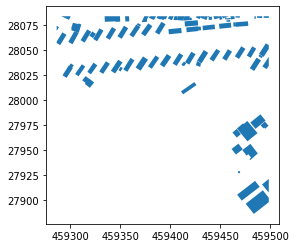

In [45]:
bldgs.plot()

## Create Labels

In [46]:
import os
from shutil import rmtree
if os.path.isdir('buildings'):
    rmtree('buildings') #TODO: what does rmtree do??
os.makedirs('buildings/true')
os.makedirs('buildings/false')

### Concatenate All buildings into a multipolygon
We are not interested in individual buildings, so we will convert all buildings into one multipolgon. Because all we want to know if a chip has any buildings

In [77]:
type(bldgs['geometry'].values)

geopandas.array.GeometryArray

In [47]:
from shapely.geometry import MultiPolygon
bldgs_grp = MultiPolygon(bldgs['geometry'].values)

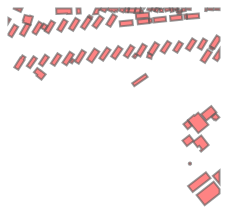

In [48]:
bldgs_grp

## Chipping the image
- False label to chips with no buildings
- True label to chips with buildings
- Image of size 6000x6000 will contain 100 chips of size 600x600


In [49]:
png_size = 600

In [73]:
def check_for_buildings_using_gdf(chip_bbox, buildings_gdf):
    chip_bbox_gdf = gpd.GeoDataFrame({'geometry': [chip_bbox]}, crs=p['crs'])
    
    # check if chip has buildings
    chip_bldgs = gpd.overlay(buildings_gdf, chip_bbox_gdf, how='intersection')
    return chip_bldgs.shape[0] != 0

def check_for_buildings_using_polygon(chip_bbox, buildings_mp):
    return chip_bbox.intersects(buildings_mp)

with rasterio.open(f'{project_dir}/img.tif') as src:
    width = src.width
    height =  src.height
    i = 0

    for w in range(0, width, png_size):
        j = 0
        for h in range(0, height, png_size):
            # Create chip 
            win = Window(col_off = w, row_off = h, width=png_size, height=png_size)
            chip = src.read(window = win)
            p = src.profile.copy()
            p['width'] = win.width
            p['height'] = win.height
            p['transform'] = src.window_transform(win)

            # chip bounding box
            left, top = p['transform'] * (0, 0)
            right, bottom = p['transform'] * (p['width'], p['height'])
            chip_bbox = Polygon([(left, bottom), (left, top), (right, top), (right, bottom)])


            #chip_bldgs.plot() # check if image is divided properly

            # chip_has_bldgs = check_for_buildings_using_gdf(chip_bbox, buildings) 
            chip_has_bldgs = check_for_buildings_using_polygon(chip_bbox, bldgs_grp)
            
             # write the chips
            if (chip_has_bldgs):
                with rasterio.open(f'buildings/true/chip_{i}_{j}', 'w', **p) as dst:
                    dst.write(chip)
            else:
                with rasterio.open(f'buildings/false/chip_{i}_{j}', 'w', **p) as dst:
                    dst.write(chip)

            j += 1
        i +=1 



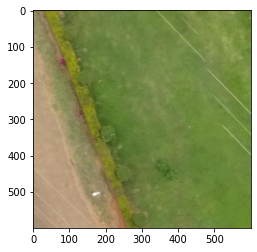

In [74]:
with rasterio.open(f'buildings/false/{os.listdir("buildings/false")[6]}', 'r') as src:
    img = src.read()
plt.imshow(img.T)

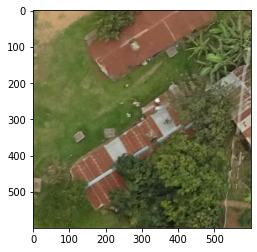

In [75]:
with rasterio.open(f'buildings/true/{os.listdir("buildings/true")[4]}', 'r') as src:
    img = src.read()
plt.imshow(img.T)